# 2. Modeling Probability of Default

Modeling the probability that a loan defaults is critical to our investment strategy. After our exploration of 2013 and 2014 data, we select predictors that present promising separations between defaulted and repaid loans. We also make sure not to use any predictors capturing information that we would not have at the time of selecting which loans to invest in.
<hr>

### Summary of variables

**Response:**

Newly defined variable, `paid`, which was a binary variable indicating whether a loan had any status other than 'Fully Paid'. 

**Predictors:**

- `funded_amnt`: The total amount committed to that loan at that point in time.
- `home_ownership` : The home ownership status provided by the borrower during registration or obtained from the credit report.    
- `int_rate` : Interest Rate on the loan.
- `purpose` : A category provided by the borrower for the loan request.
- `annual_inc`: The self-reported annual income provided by the borrower during registration.
- `verification_status`: Indicates if income was verified by LC, not verified, or if the income source was verified.
- `dti`: Debt to income ratio - ratio calculated using the borrower's total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower's self-reported monthly income.
- `revol_util`:  Revolving utilization - ratio of total current balance to credit limit for all revolving accounts.
- `grade`: Lending club assigned loan grade.
- `term`: The number of payments on the loan. Values are in months and can be either 36 or 60.

    *We use one hot encoding for the categorical variables (employment length, home ownership, verification status, grade and purpose).*    
    *We normalize all columns with values that are not percentages (funded amount, annual income and debt-to-income ratio).*   
    *We drop rows with null values in any of the columns.*

<hr>

In [1]:
import pandas as pd
import datetime
from sklearn import preprocessing
from imblearn.over_sampling import SMOTE
import pickle
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import matplotlib.cm as cm

In [2]:
## read in csv files
data_2013 = pd.read_csv("../data/2012_13_loan_data/LoanStats3b.csv", low_memory = False, encoding='latin-1')

data_a_2014 = pd.read_csv("../data/2014_loan_data/LoanStats_2014_A.csv", low_memory = False);
data_b_2014 = pd.read_csv("../data/2014_loan_data/LoanStats_2014_B.csv", low_memory = False);
data_c_2014 = pd.read_csv("../data/2014_loan_data/LoanStats_2014_C.csv", low_memory = False);
data_d_2014 = pd.read_csv("../data/2014_loan_data/LoanStats_2014_D.csv", low_memory = False);

data_a_2015 = pd.read_csv("../data/2015_loan_data/LoanStats_2015_A.csv", low_memory = False);
data_b_2015 = pd.read_csv("../data/2015_loan_data/LoanStats_2015_B.csv", low_memory = False);
data_c_2015 = pd.read_csv("../data/2015_loan_data/LoanStats_2015_C.csv", low_memory = False);
data_d_2015 = pd.read_csv("../data/2015_loan_data/LoanStats_2015_D.csv", low_memory = False);
data_e_2015 = pd.read_csv("../data/2015_loan_data/LoanStats_2015_E.csv", low_memory = False);
data_f_2015 = pd.read_csv("../data/2015_loan_data/LoanStats_2015_F.csv", low_memory = False);
data_g_2015 = pd.read_csv("../data/2015_loan_data/LoanStats_2015_G.csv", low_memory = False);
data_h_2015 = pd.read_csv("../data/2015_loan_data/LoanStats_2015_H.csv", low_memory = False);

## concatenate data into training and test sets
data_train = pd.concat([data_a_2014, data_b_2014, data_c_2014, data_d_2014, data_2013], ignore_index=True)

data_2015 = pd.concat([data_a_2015, data_b_2015, data_c_2015, data_d_2015, 
                       data_e_2015, data_f_2015, data_g_2015, data_h_2015], 
                       ignore_index=True)

In [3]:
data_test = data_2015.copy()
# create response var
data_test["paid"] = 1
data_test.loc[data_test.loan_status == 'Fully Paid', 'paid'] = 0

In [4]:
data_train_ = data_train.copy()
# create response var
data_train_["paid"] = 1
data_train_.loc[data_train_.loan_status == 'Fully Paid', 'paid'] = 0

### MAKE TABLE TO SHOW IMBALANCE OF CLASSES
class_cts = data_train_.groupby(['paid']).agg({
    'paid' : 'count'})
class_cts['Percent'] = class_cts.paid/len(data_train)
class_cts.index = ['repaid','defaulted']
class_cts.columns = ['number of loans', 'percent of loans']

### ADD IN SMOTE
def split_data(df, cols):
    x = df.drop(cols, axis = 1)
    y = df.paid
    return x, y
cols_to_drop_training = []
x_train_initial, y_train_initial = split_data(data_train_.loc[:, ['paid', 'funded_amnt']], cols_to_drop_training)
sm = SMOTE(random_state=1, ratio = 1.0)
x_train, y_train = sm.fit_sample(x_train_initial, y_train_initial)
class_cts['SMOTE number of loans'] = [sum(y_train),len(y_train) - sum(y_train)]
class_cts['SMOTE percent of loans'] = [sum(y_train)/len(y_train), 1-sum(y_train)/len(y_train)]

In [5]:
train = pd.read_csv("../lipika/cleaned_2013_14", low_memory = False);
test = pd.read_csv("../lipika/cleaned_2015")

In [6]:
baseline_test = (len(data_test) - sum(data_test.paid))/len(data_test)
baseline_train = (len(data_train_) - sum(data_train_.paid))/len(data_train_)

### Handling Imbalanced Class

The machine learning algorithms we select to predict future loans as defaulting or not defaulting have trouble learning to predict underrepresented classes. As seen in the table below, the defaulted class in the training data is under represented. To address this class imbalance problem, we use synthesis of new minority class instances ([SMOTE](https://jair.org/index.php/jair/article/view/10302/24590)). For each minority class, SMOTE calculates the k nearest neighbors. Depending on the amount of oversampling required, one or more of the k-nearest neighbors are selecte to create synthetic examples to augment the training dataset. We oversample the defaulted loan class to achieve a 50-50 split of classes using the `imbalanced-learn` library.

In [7]:
class_cts.round(2)

,number of loans,percent of loans,SMOTE number of loans,SMOTE percent of loans
repaid,289177,0.78,289177,0.5
defaulted,81266,0.22,289177,0.5


<hr>

### Machine Learning Models

Our goal is to achieve the highly accurate predictions of the probability of a loan defaulting with our selected features, and use this predicted probability as an input to our investment strategy. We use a suite of models to predict this probability and conduct hyperparameter searches using grid search. The models we explore are listed below with their tuned hyperparameters.

- Logistic Regression
- QDA
- Random Forest
    - Max depth: 12
    - Number of estimators: 50
- AdaBoost
    - max_depth: None
    - Number of estimators: 50
    - learning_rate: 1.0
- Light GBM
    - Learning_rate: 0.1
    - boosting_type: gradient boosted decision tree
    - max_depth: 15

- Neural Network: Multi-layer Perceptron
    - Nodes by layer: 40, 20, 10

The baseline accuracy, i.e. accuracy achieved when the majority class (repaid loans) is always predicted, is 0.82 on the training set and 0.78 on the test set. While most of our models do not achieve baseline accuracy, we attribute this to discarding variables we identify as potentially containing information about protected classes.

As displayed in the table below, the highest test accuracy is achieved by the neural network, followed by QDA. However, QDA achieves a high test accuracy because it predominantly predicts that loans are repaid (only 0.07\% of loans are predicted to default). A dive into QDA's training accuracy reveals a similar pattern, where only 3.4\% of the loans are predicted to default, despite 50% of the loans resulting in true defaults. Given this trend, we don't trust that QDA has learnt the nuances of our training data, so we choose the next contender, logistic regression, to take forward to our return on investment analysis, along with the neural network.

As this is a highly imbalanced problem, we seek to confirm that our best contendors from an accuracy standpoint do maximize the area under the receiver operating curve (AUC). As shown in the table, the highest AUC is achieved by the logistic regression model, followed by the neural network, confirming our selection.

<hr>

In [8]:
import warnings
warnings.filterwarnings("ignore")

with open('../lipika/df_train_dict.pickle', 'rb') as handle:
    df_train_dict = pickle.load(handle)
with open('../lipika/df_test_dict.pickle', 'rb') as handle:
    df_test_dict = pickle.load(handle)
    
with open('../lipika/lgbm_test_no_smote.pickle', 'rb') as handle:
    lgbm_test_dict = pickle.load(handle)
    
with open('../lipika/lgbm_train_no_smote.pickle', 'rb') as handle:
    lgbm_train_dict = pickle.load(handle)

with open('../bhaven/RF_tuned_test_preds.pickle', 'rb') as handle:
    rf_test_dict = pickle.load(handle)
    
with open('../bhaven/RF_tuned_training_preds.pickle', 'rb') as handle:
    rf_train_dict = pickle.load(handle)
    
keylgbmtest = list(lgbm_test_dict.keys())[0]
keylgbmtrain = list(lgbm_train_dict.keys())[0]
keyrftest = list(rf_test_dict.keys())[0]
keyrftrain = list(rf_train_dict.keys())[0]
x = list(df_train_dict.keys())[0]
y = list(df_train_dict.keys())[1]
df_train_dict['adaboost'] = df_train_dict.pop(x)
df_train_dict['logreg'] = df_train_dict.pop(y)
x = list(df_test_dict.keys())[0]
y = list(df_test_dict.keys())[1]
df_test_dict['adaboost'] = df_test_dict.pop(x)
df_test_dict['logreg'] = df_test_dict.pop(y)

## Get all datasets
train_preds_lgbm = lgbm_train_dict[keylgbmtrain]
train_preds_adaboost = df_train_dict['adaboost']
train_preds_logreg = df_train_dict['logreg']
train_preds_qda = pd.read_csv('../lipika/qda_preds_training')
train_preds_nn = pd.read_csv('../hugo/NN_train.csv', sep='\t')
train_preds_rf = rf_train_dict[keyrftrain]


test_preds_lgbm = lgbm_test_dict[keylgbmtest]
test_preds_adaboost = df_test_dict['adaboost']
test_preds_logreg = df_test_dict['logreg']
test_preds_qda = pd.read_csv('../lipika/qda_preds_test')
test_preds_nn = pd.read_csv('../hugo/NN_test.csv', sep='\t')
test_preds_rf = rf_test_dict[keyrftest]

## lists of models 
list_of_model_names = ['Light GBM', 'AdaBoost', 'Logistic Regression', 
                       'Quadratic Discriminant Analysis', 'Neural Network',
                       'Random Forest'
                      ]

list_of_train_dfs = [train_preds_lgbm, 
                     train_preds_adaboost, 
                     train_preds_logreg,
                     train_preds_qda,
                     train_preds_nn,
                     train_preds_rf
                    ]

list_of_test_dfs = [test_preds_lgbm,
                    test_preds_adaboost, 
                    test_preds_logreg,
                    test_preds_qda,
                    test_preds_nn, 
                    test_preds_rf
                   ]
### delete the bad data with 0.567 for all rows
for key, df in enumerate(list_of_train_dfs):
    df = df[df.int_rate < 0.5]
for key, df in enumerate(list_of_test_dfs):
    df = df[df.int_rate < 0.5]

In [9]:
roc_auc_score_training = []
accuracy_training = []

roc_auc_score_testing = []
accuracy_testing = []

for train_df in list_of_train_dfs:
    
    roc_auc_score_training.append(roc_auc_score(train_df['true_val'], train_df['proba']))
    accuracy_training.append(accuracy_score(train_df['true_val'], train_df['pred']))

for test_df in list_of_test_dfs:
    
    roc_auc_score_testing.append(roc_auc_score(test_df['true_val'], test_df['proba']))
    accuracy_testing.append(accuracy_score(test_df['true_val'], test_df['pred']))

### Training and test accuracies by model

In [10]:
display_model_results = pd.DataFrame(
    {'Training Accuracy' : accuracy_training,
     'Training AUC' : roc_auc_score_training, 
     'Test Accuracy' : accuracy_testing,
     'Test AUC' : roc_auc_score_testing
    }, index = list_of_model_names)

display_model_results = display_model_results.sort_values(by = 'Test AUC', ascending=0)
display_model_results.round(3)

,Training Accuracy,Training AUC,Test Accuracy,Test AUC
Logistic Regression,0.655,0.713,0.746,0.724
Neural Network,0.676,0.708,0.781,0.714
Light GBM,0.786,0.702,0.702,0.641
Random Forest,0.694,0.720,0.718,0.637
AdaBoost,0.896,0.960,0.663,0.622
Quadratic Discriminant Analysis,0.535,0.535,0.778,0.502


In [11]:
fpr_lgbm, tpr_lgbm, thresholds_lgbm = roc_curve(train_preds_lgbm['true_val'], 
                                                train_preds_lgbm['proba'])
auc_lgbm = auc(fpr_lgbm, tpr_lgbm)

fpr_logreg, tpr_logreg, thresholds_logreg = roc_curve(train_preds_logreg['true_val'], 
                                                      train_preds_logreg['proba'])
auc_logreg = auc(fpr_logreg, tpr_logreg)

fpr_adaboost, tpr_adaboost, thresholds_adaboost = roc_curve(train_preds_adaboost['true_val'], 
                                                            train_preds_adaboost['proba'])
auc_adaboost = auc(fpr_adaboost, tpr_adaboost)

fpr_qda, tpr_qda, thresholds_qda = roc_curve(train_preds_qda['true_val'], 
                                             train_preds_qda['proba'])
auc_qda = auc(fpr_qda, tpr_qda)

fpr_nn, tpr_nn, thresholds_nn = roc_curve(train_preds_nn['true_val'], 
                                          train_preds_nn['proba'])
auc_nn = auc(fpr_nn, tpr_nn)

fpr_rf, tpr_rf, thresholds_rf = roc_curve(train_preds_rf['true_val'], 
                                          train_preds_rf['proba'])
auc_rf = auc(fpr_rf, tpr_rf)

In [12]:
fpr_te_lgbm, tpr_te_lgbm, thresholds_lgbm = roc_curve(test_preds_lgbm['true_val'], 
                                                test_preds_lgbm['proba'])
auc_te_lgbm = auc(fpr_te_lgbm, tpr_te_lgbm)

fpr_te_logreg, tpr_te_logreg, thresholds_logreg = roc_curve(test_preds_logreg['true_val'], 
                                                      test_preds_logreg['proba'])
auc_te_logreg = auc(fpr_te_logreg, tpr_te_logreg)

fpr_te_adaboost, tpr_te_adaboost, thresholds_adaboost = roc_curve(test_preds_adaboost['true_val'], 
                                                            test_preds_adaboost['proba'])
auc_te_adaboost = auc(fpr_te_adaboost, tpr_te_adaboost)

fpr_te_qda, tpr_te_qda, thresholds_qda = roc_curve(test_preds_qda['true_val'], 
                                             test_preds_qda['proba'])
auc_te_qda = auc(fpr_te_qda, tpr_te_qda)

fpr_te_nn, tpr_te_nn, thresholds_nn = roc_curve(test_preds_nn['true_val'], 
                                          test_preds_nn['proba'])
auc_te_nn = auc(fpr_te_nn, tpr_te_nn)

fpr_te_rf, tpr_te_rf, thresholds_rf = roc_curve(test_preds_rf['true_val'], 
                                          test_preds_rf['proba'])
auc_te_rf = auc(fpr_te_rf, tpr_te_rf)


## Probability of Default Distributions for Training Data

In [34]:
import seaborn as sns
import copy

In [35]:
models = [train_preds_lgbm, train_preds_rf, train_preds_adaboost, 
          train_preds_qda, train_preds_nn, train_preds_logreg]

model_names = ['LGBM', 'Random Forest', 'AdaBoost', 
          'QDA', 'Neural Net', 'Logistic Regression']

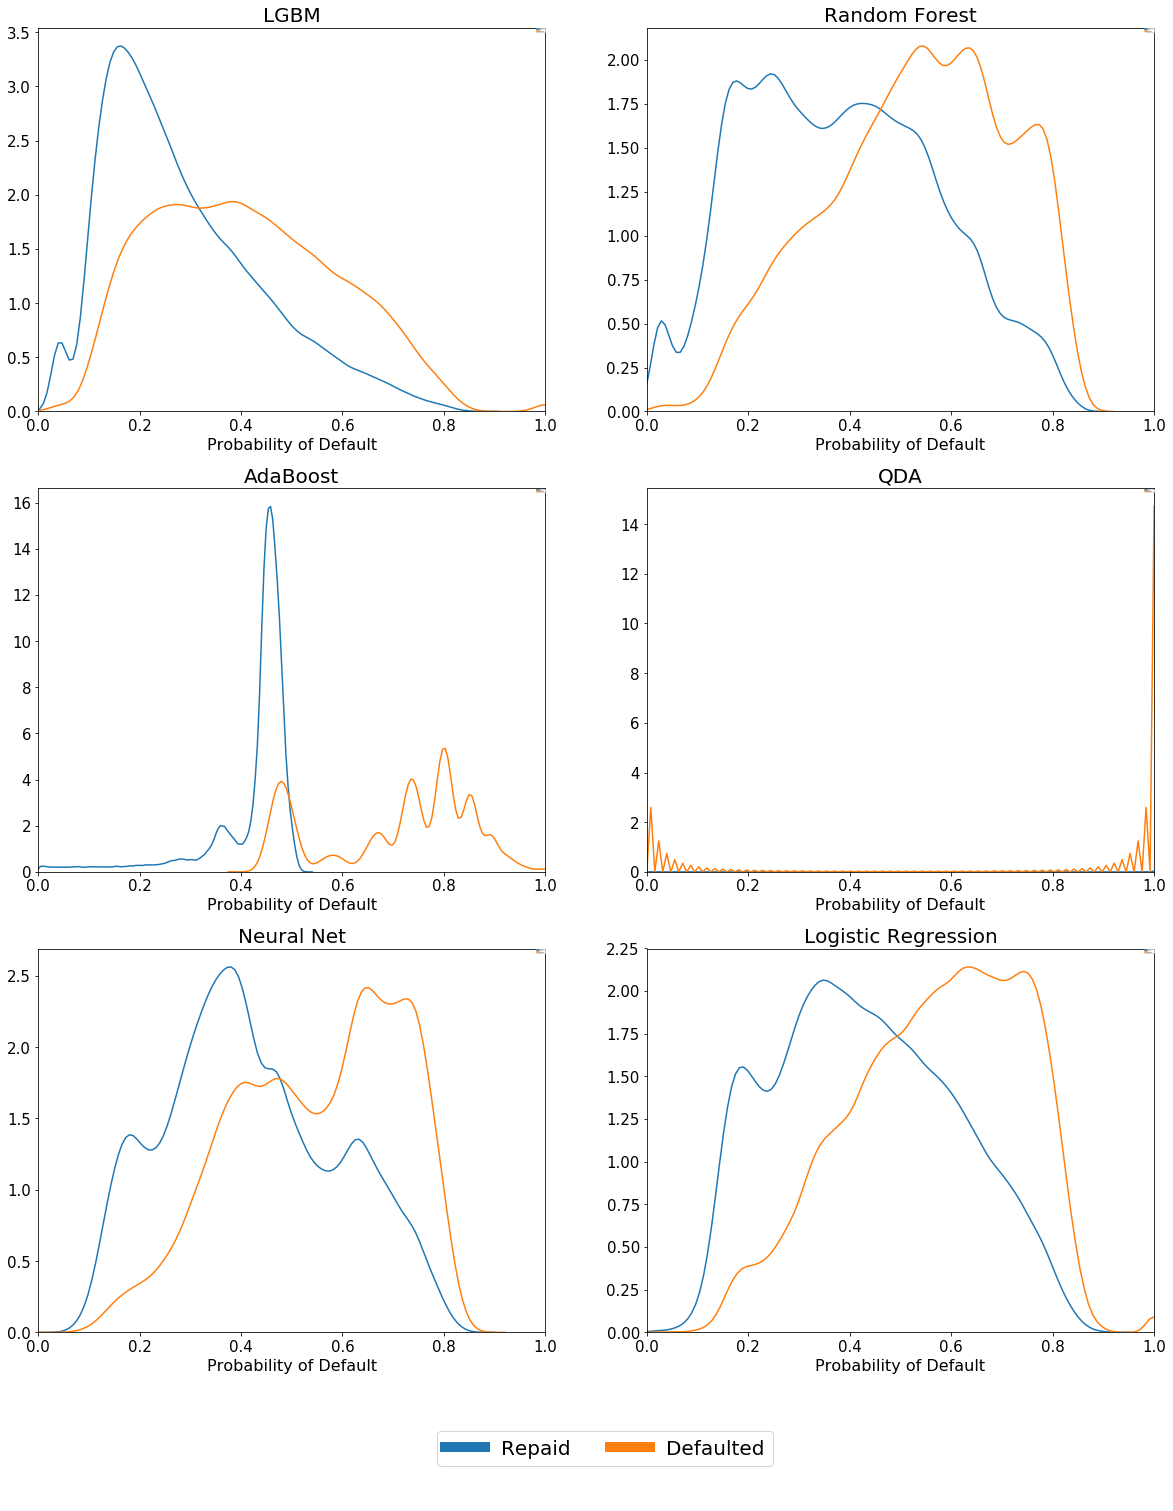

In [39]:
fig = plt.figure(figsize=(20, 24)) 
fig.subplots_adjust(hspace=0.2, wspace=0.2)

for i, model in enumerate(models):
    
    ax = plt.subplot(3,2, i+1)
    sns.kdeplot(model.loc[model.true_val == 0, 'proba'], label = 'Repaid')
    sns.kdeplot(model.loc[model.true_val == 1, 'proba'], label = 'Defaulted')
    ax.tick_params(labelsize = 15)
    ax.set_xlim(0, 1)
    ax.set_xlabel('Probability of Default', fontsize = 16)
    ax.set_title('{0}'.format(model_names[i]), fontsize = 20)
    ax.legend(loc = 'best', fontsize = -1)
    
handles, labels = ax.get_legend_handles_labels()
handles = [copy.copy(ha) for ha in handles ]
[ha.set_linewidth(10) for ha in handles ]
fig.legend(handles, labels, loc='lower center', ncol = 2, fontsize = 20, bbox_to_anchor = (0.42, 0.02))
plt.show()

Heuristically, it mattered to us that our models be able to assign different spectrums of default probabilities to loans that went on to default compared with those that repaid succesfully. We considered the probability distributions associated with our two outcome classes in the training data - aware of the fact that we shouldn't read too much into this since there was clearly the chance our models were overfit.

Financial data is notoriously noisy, so it was promising that our models were generally able to differentiate between the different outcomes based on our input data. We were interesed in quantifying the predictive power of our models, hence we used ROC AUC scores as well as accuracy scores to make our final decision on which models to take forwards.

<hr>

### Area under the receiver operating characteristic (ROC) curve for training and test data ###

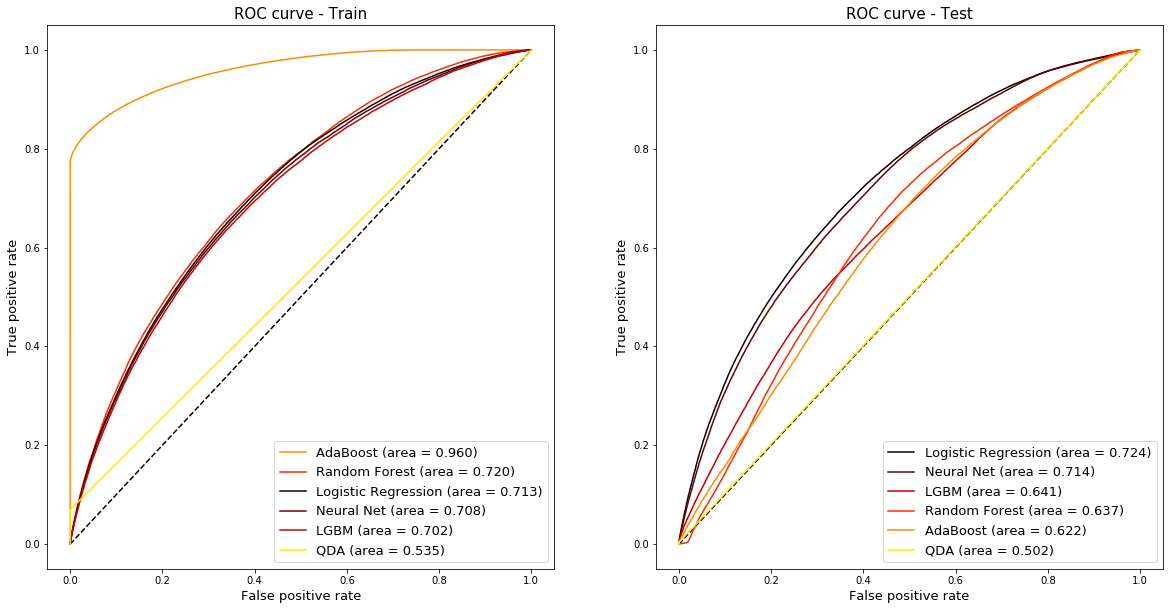

In [13]:
c = []
for i in np.arange(18):
    c.append(cm.hot(i/7.,1))


fig, ax = plt.subplots(1,2,figsize=(20,10))

ax[0].plot([0, 1], [0, 1], 'k--')
ax[0].plot(fpr_adaboost, tpr_adaboost, label='{} (area = {:.3f})'.format('AdaBoost',auc_adaboost), c = c[4])
ax[0].plot(fpr_rf, tpr_rf, label='{} (area = {:.3f})'.format('Random Forest',auc_rf), c = c[3])
ax[0].plot(fpr_logreg, tpr_logreg, label='{} (area = {:.3f})'.format('Logistic Regression',auc_logreg)
           , c = c[0])
ax[0].plot(fpr_nn, tpr_nn, label='{} (area = {:.3f})'.format('Neural Net',auc_nn), c = c[1])
ax[0].plot(fpr_lgbm, tpr_lgbm, label='{} (area = {:.3f})'.format('LGBM',auc_lgbm), c = c[2])
ax[0].plot(fpr_qda, tpr_qda, label='{} (area = {:.3f})'.format('QDA',auc_qda), c = c[5])
ax[0].set_xlabel('False positive rate', fontsize = 13)
ax[0].set_ylabel('True positive rate', fontsize = 13)
ax[0].set_title('ROC curve - Train', fontsize = 15)
ax[0].legend(loc='lower right', fontsize = 13);


ax[1].plot([0, 1], [0, 1], 'k--')
ax[1].plot(fpr_te_logreg, tpr_te_logreg, label='{} (area = {:.3f})'.format('Logistic Regression',auc_te_logreg),
           c = c[0])
ax[1].plot(fpr_te_nn, tpr_te_nn, label='{} (area = {:.3f})'.format('Neural Net',auc_te_nn),  c = c[1])
ax[1].plot(fpr_te_lgbm, tpr_te_lgbm, label='{} (area = {:.3f})'.format('LGBM',auc_te_lgbm),  c = c[2])
ax[1].plot(fpr_te_rf, tpr_te_rf, label='{} (area = {:.3f})'.format('Random Forest',auc_te_rf),  c = c[3])
ax[1].plot(fpr_te_adaboost, tpr_te_adaboost, label='{} (area = {:.3f})'.format('AdaBoost',auc_te_adaboost)
           ,  c = c[4])
ax[1].plot(fpr_te_qda, tpr_te_qda, label='{} (area = {:.3f})'.format('QDA',auc_te_qda),  c = c[5])
ax[1].set_xlabel('False positive rate', fontsize = 13)
ax[1].set_ylabel('True positive rate', fontsize = 13)
ax[1].set_title('ROC curve - Test', fontsize = 15)
ax[1].legend(loc='lower right', fontsize = 13);

plt.show();

<hr>

**Analysis**

From these results, it was clear we should take the Logistic Regression model and our MLP forward as our final models. Financial data is notoriously noisy, so the fact that both these models achieved close to/superior accuracy scores compared with the the baseline accuracy, and that both maintained their AUC across the training and test sets.

<hr>